In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os

BASE_DIR = "/content/drive/MyDrive/Semeval_Polar"
DATA_DIR = os.path.join(BASE_DIR, "Data")
OUT_DIR  = os.path.join(BASE_DIR, "Submissions")
os.makedirs(OUT_DIR, exist_ok=True)

# ✅ Subtask-1 dosya adını Drive'daki gerçeğe göre ayarla
TRAIN_PATH = os.path.join(DATA_DIR, "tur_subtask1.csv")                 # <-- gerekirse değiştir
TEST_PATH  = os.path.join(DATA_DIR, "tur_subtask1_test.csv")   # <-- yoksa split ile gideriz

print("TRAIN exists?", os.path.exists(TRAIN_PATH), TRAIN_PATH)
print("TEST  exists?", os.path.exists(TEST_PATH),  TEST_PATH)
print("OUT_DIR:", OUT_DIR)


Mounted at /content/drive
TRAIN exists? True /content/drive/MyDrive/Semeval_Polar/Data/tur_subtask1.csv
TEST  exists? True /content/drive/MyDrive/Semeval_Polar/Data/tur_subtask1_test.csv
OUT_DIR: /content/drive/MyDrive/Semeval_Polar/Submissions


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score

RANDOM_STATE = 42
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 4)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
URL_RE     = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
MULTI_WS   = re.compile(r"\s+")

def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" <URL> ", s)
    s = MENTION_RE.sub(" <USER> ", s)
    s = HASHTAG_RE.sub(" <HASHTAG> ", s)
    s = MULTI_WS.sub(" ", s).strip()
    return s


In [ ]:
df = pd.read_csv(TRAIN_PATH)
print("Columns:", list(df.columns))
print("Rows:", len(df))
display(df.head(3))

# required columns
if "text" not in df.columns:
    raise ValueError("Train must have a 'text' column.")
if "polarization" not in df.columns:
    raise ValueError("Train must have a 'polarization' column (0/1).")

# optional lang filter (TR only)
df2 = df.copy()
if "lang" in df2.columns:
    df2["lang"] = df2["lang"].astype(str).str.lower()
    df2 = df2[df2["lang"].eq("tur") | df2["lang"].eq("tr")].copy()
    print("Filtered by lang (tur/tr). Rows:", len(df2))
else:
    print("No 'lang' column → assuming already Turkish-only.")

df2["text"] = df2["text"].astype(str).str.strip()
df2 = df2[df2["text"].str.len() > 0].copy()

df2["text_norm"] = df2["text"].apply(normalize_text)

df2["polarization"] = pd.to_numeric(df2["polarization"], errors="coerce")
df2 = df2[df2["polarization"].isin([0,1])].copy()

# ensure id exists
if "id" not in df2.columns:
    df2["id"] = np.arange(len(df2))

X_all = df2["text_norm"].tolist()
y_all = df2["polarization"].astype(int).values

print("Final train size:", len(df2))
print("Class counts:", pd.Series(y_all).value_counts().to_dict())
display(df2[["id","polarization","text"]].head(3))


Columns: ['id', 'text', 'polarization']
Rows: 2364


,id,text,polarization
0,tur_153d607a6d1a1130e696a94db6588075,Çıldırmam an meselesi Ben eskiden dövme yaptır...,0
1,tur_67a124df33f922df9430d8510716173f,2 Yurtlarını işgal ettiği mazlum v e masum Fil...,1
2,tur_0b8d62766d1198185bda9f3940e2d121,@USER Bereket Versin. İHA’ dan ateş edildiğind...,0


No 'lang' column → assuming already Turkish-only.
Final train size: 2364
Class counts: {0: 1209, 1: 1155}


,id,polarization,text
0,tur_153d607a6d1a1130e696a94db6588075,0,Çıldırmam an meselesi Ben eskiden dövme yaptır...
1,tur_67a124df33f922df9430d8510716173f,1,2 Yurtlarını işgal ettiği mazlum v e masum Fil...
2,tur_0b8d62766d1198185bda9f3940e2d121,0,@USER Bereket Versin. İHA’ dan ateş edildiğind...


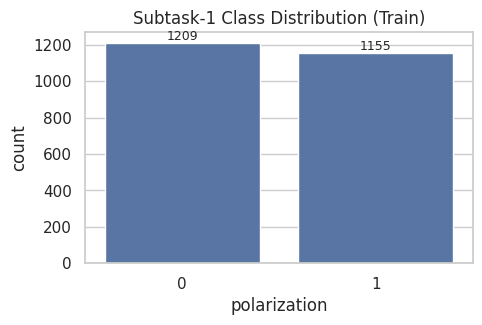

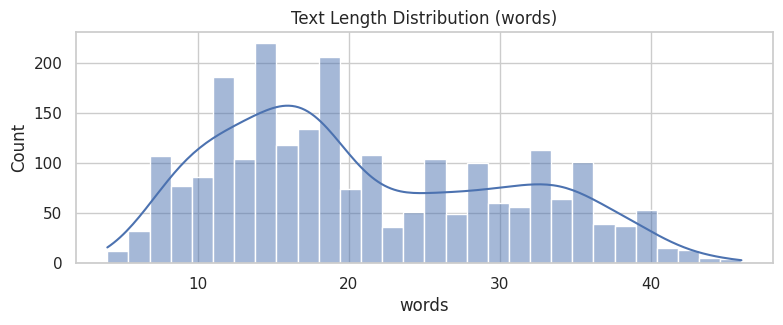

In [ ]:
# class distribution
plt.figure(figsize=(5,3))
ax = sns.countplot(x=df2["polarization"])
plt.title("Subtask-1 Class Distribution (Train)")
plt.xlabel("polarization"); plt.ylabel("count")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.show()

# text length
lens = df2["text_norm"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(9,3))
sns.histplot(lens, bins=30, kde=True)
plt.title("Text Length Distribution (words)")
plt.xlabel("words")
plt.show()


In [ ]:
has_test_file = os.path.exists(TEST_PATH)

if has_test_file:
    # test set external: we still keep a dev split from train for evaluation
    X_train, X_dev, y_train, y_dev = train_test_split(
        X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
    )
    print("External test exists ✅ → using train/dev split for eval.")
else:
    # no external test: split into train/dev and later you can still create "pseudo-test" predictions
    X_train, X_dev, y_train, y_dev = train_test_split(
        X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
    )
    print("No external test → using train/dev split only.")

print("Train:", len(X_train), "Dev:", len(X_dev))


External test exists ✅ → using train/dev split for eval.
Train: 1891 Dev: 473


In [ ]:
MODEL_NAME = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class BinaryTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

MAX_LEN = 256
train_ds = BinaryTextDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
dev_ds   = BinaryTextDataset(X_dev,   y_dev,   tokenizer, max_len=MAX_LEN)

print("Datasets ready:", len(train_ds), len(dev_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Datasets ready: 1891 473


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

print("Model ready ✅")


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready ✅


In [ ]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=32, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 4
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

print("steps:", total_steps, "| warmup:", warmup_steps)


steps: 476 | warmup: 47


Epoch 1/4 | loss=0.6309 | dev micro@0.5=0.7400 | dev macro@0.5=0.7354
Epoch 2/4 | loss=0.4417 | dev micro@0.5=0.7674 | dev macro@0.5=0.7659
Epoch 3/4 | loss=0.3082 | dev micro@0.5=0.7505 | dev macro@0.5=0.7480
Epoch 4/4 | loss=0.1895 | dev micro@0.5=0.7865 | dev macro@0.5=0.7865

Best dev macro@0.5: 0.7865


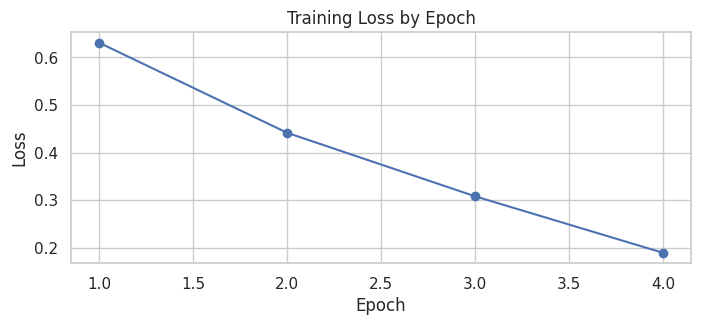

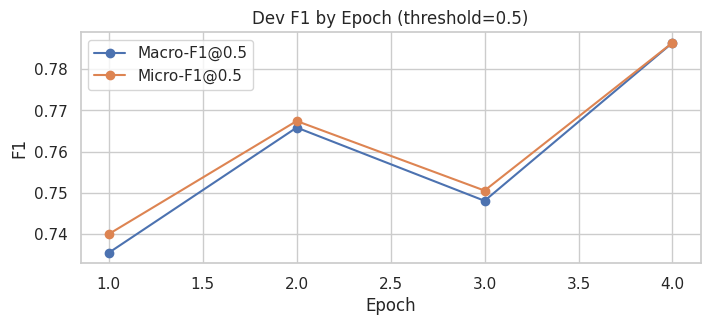

In [ ]:
def softmax_np(logits):
    e = np.exp(logits - logits.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

def eval_probs(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].cpu().numpy()
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out.logits.detach().cpu().numpy()
            all_logits.append(logits)
            all_labels.append(labels)
    logits = np.vstack(all_logits)
    labels = np.concatenate(all_labels)
    probs = softmax_np(logits)[:, 1]  # P(class=1)
    return probs, labels

best_macro = -1
best_state = None

train_losses, dev_macros, dev_micros = [], [], []

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    train_losses.append(avg_loss)

    p_dev, y_dev_np = eval_probs(model, dev_loader)
    yhat05 = (p_dev >= 0.5).astype(int)

    micro = f1_score(y_dev_np, yhat05, average="micro", zero_division=0)
    macro = f1_score(y_dev_np, yhat05, average="macro", zero_division=0)
    dev_micros.append(micro)
    dev_macros.append(macro)

    print(f"Epoch {epoch}/{num_epochs} | loss={avg_loss:.4f} | dev micro@0.5={micro:.4f} | dev macro@0.5={macro:.4f}")

    if macro > best_macro:
        best_macro = macro
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest dev macro@0.5:", round(best_macro, 4))

# curves
plt.figure(figsize=(8,3))
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o")
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8,3))
plt.plot(range(1, len(dev_macros)+1), dev_macros, marker="o", label="Macro-F1@0.5")
plt.plot(range(1, len(dev_micros)+1), dev_micros, marker="o", label="Micro-F1@0.5")
plt.title("Dev F1 by Epoch (threshold=0.5)")
plt.xlabel("Epoch"); plt.ylabel("F1")
plt.legend()
plt.show()


Best threshold: 0.27 | Best Dev Macro-F1: 0.803


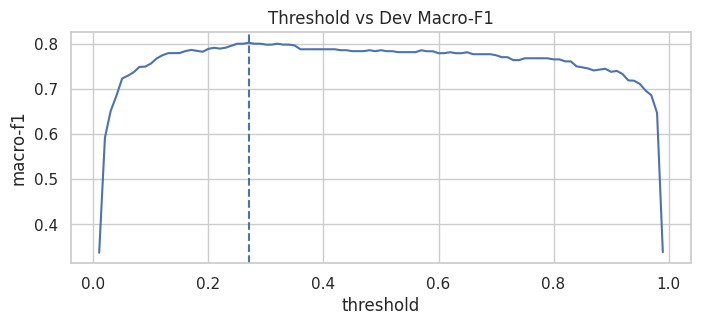


Accuracy: 0.8034
Micro-F1: 0.8034
Macro-F1: 0.803
ROC-AUC: 0.8525

Classification report:
              precision    recall  f1-score   support

           0     0.8531    0.7438    0.7947       242
           1     0.7634    0.8658    0.8114       231

    accuracy                         0.8034       473
   macro avg     0.8082    0.8048    0.8030       473
weighted avg     0.8093    0.8034    0.8028       473



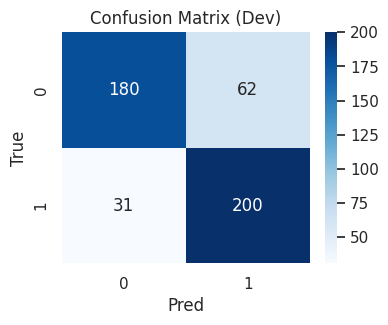

In [ ]:
# load best checkpoint
model.load_state_dict(best_state)

p_dev, y_dev_np = eval_probs(model, dev_loader)

grid = np.linspace(0.01, 0.99, 99)
f1s = []
for t in grid:
    yhat = (p_dev >= t).astype(int)
    f1s.append(f1_score(y_dev_np, yhat, average="macro", zero_division=0))

best_i = int(np.argmax(f1s))
best_thr = float(grid[best_i])
best_f1 = float(f1s[best_i])

print("Best threshold:", round(best_thr, 3), "| Best Dev Macro-F1:", round(best_f1, 4))

# plot threshold curve
plt.figure(figsize=(8,3))
plt.plot(grid, f1s)
plt.axvline(best_thr, linestyle="--")
plt.title("Threshold vs Dev Macro-F1")
plt.xlabel("threshold"); plt.ylabel("macro-f1")
plt.show()

# final report @ best_thr
yhat = (p_dev >= best_thr).astype(int)
print("\nAccuracy:", round(accuracy_score(y_dev_np, yhat), 4))
print("Micro-F1:", round(f1_score(y_dev_np, yhat, average="micro", zero_division=0), 4))
print("Macro-F1:", round(f1_score(y_dev_np, yhat, average="macro", zero_division=0), 4))
try:
    print("ROC-AUC:", round(roc_auc_score(y_dev_np, p_dev), 4))
except Exception:
    print("ROC-AUC: could not be computed")

print("\nClassification report:")
print(classification_report(y_dev_np, yhat, digits=4, zero_division=0))

cm = confusion_matrix(y_dev_np, yhat)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Dev)")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


In [ ]:
if os.path.exists(TEST_PATH):
    df_test = pd.read_csv(TEST_PATH)

    if "text" not in df_test.columns:
        raise ValueError("Test must contain 'text' column")

    df_test["text"] = df_test["text"].astype(str).str.strip()
    df_test = df_test[df_test["text"].str.len() > 0].copy()
    df_test["text_norm"] = df_test["text"].apply(normalize_text)

    if "id" not in df_test.columns:
        df_test["id"] = np.arange(len(df_test))

    # build test dataset (dummy labels)
    test_ds = BinaryTextDataset(
        df_test["text_norm"].tolist(),
        np.zeros(len(df_test), dtype=int),
        tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # predict probs
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out.logits.detach().cpu().numpy()
            probs.append(softmax_np(logits)[:, 1])
    p_test = np.concatenate(probs)

    pred = (p_test >= best_thr).astype(int)

    sub = pd.DataFrame({
        "id": df_test["id"],
        "polarization": pred
    })

    out_path = os.path.join(OUT_DIR, "subtask1_tr_bert_len256_ep4_thr99.csv")
    sub.to_csv(out_path, index=False)

    print("Saved submission:", out_path)
    display(sub.head(10))
else:
    print("No external TEST_PATH found → submission not generated.")


Saved submission: /content/drive/MyDrive/Semeval_Polar/Submissions/subtask1_tr_bert_len256_ep4_thr99.csv


,id,polarization
0,tur_51d5ae56681ac60f71111d88cce7c322,0
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,0
2,tur_2560161367a0747f32070ba1a54be275,1
3,tur_2a45e8c804463256a9dc04328fa867c1,0
4,tur_77bd1dd03a347a23f64ae022ad17f53a,1
5,tur_ad585591cb519e07dbe602ce07c390fc,1
6,tur_f376d5c18b33dd5056271da352c400b4,1
7,tur_2ae6522870f36f45c728cff04d381fdc,0
8,tur_f0cf95b93214f3a7030187151b2ad23f,0
9,tur_e93d64ab0054e0c3b4920f0e191c3022,1


In [ ]:
import pandas as pd
print("Train size:", len(X_train), "Dev size:", len(X_dev))
print("Train class counts:", pd.Series(y_train).value_counts().to_dict())
print("Dev class counts:", pd.Series(y_dev).value_counts().to_dict())


Train size: 1891 Dev size: 473
Train class counts: {0: 967, 1: 924}
Dev class counts: {0: 242, 1: 231}
